Урок 7. Детектирование объектов

   1 Сделайте краткий обзор любой научной работы, посвящённой алгоритму для

   object detection, не рассматривавшемуся на уроке. Проведите анализ: чем

   отличается выбранная вами архитектура нейронной сети от других? В чём плюсы

   и минусы данной архитектуры? Какие могут возникнуть трудности при применении


  этой архитектуры на практике?

  Достаточно сложное задание

  2 Ссылка на репозиторий с полным кодом для обучения ssd нейросети:
   https://github.com/sergeyveneckiy/ssd-tensorflow.

   Попробуйте улучшить точность её работы и напишите отчёт (что вы пробовали

   изменить в её параметрах и как это отражалось на процессе обучения нейронной

   сети)



# Новый раздел

EfficientNet можно рассматривать как группу моделей сверточных нейронных сетей. Но с учетом некоторых тонкостей он на самом деле более эффективен, чем большинство его предшественников.

Группа моделей EfficientNet состоит из 8 моделей от B0 до B7, каждый последующий номер модели относится к вариантам с большим количеством параметров и большей точностью.

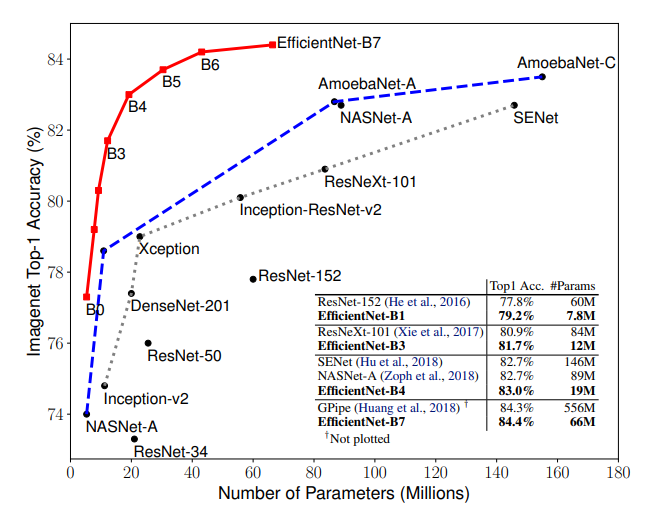

Тогда возникает вопрос: Что эффективно? Мы видим, что успех моделей в наборе данных ImageNet увеличился, поскольку они стали более сложными с 2012 года. Однако большинство из них неэффективны с точки зрения нагрузки на обработку. В последние годы были приняты более эффективные подходы к меньшим моделям. Настолько, что при уменьшении масштаба модели масштабирование выполняется по глубине, ширине и разрешению - сосредоточение внимания на всех трех в сочетании позволило добиться более эффективных результатов. Да, эффективно.

Учитывая это, архитектура модели EfficientNet должна масштабироваться в три этапа.

❄️Как работает EfficientNet
В трех основных шагах можно понять, почему это более эффективно.



Глубинная свертка + Точечная свертка: делит исходную свертку на два этапа, чтобы значительно снизить стоимость вычислений с минимальной потерей точности.
Обратное разрешение: исходные блоки ResNet состоят из слоя, который сжимает каналы, а затем слоя, который расширяет каналы. Таким образом, он связывает пропущенные соединения с богатыми слоями каналов. Однако в MBConv блоки состоят из уровня, который сначала расширяет каналы, а затем сжимает их, так что слои с меньшим количеством каналов пропускаются.
Линейное узкое место: использует линейную активацию на последнем уровне в каждом блоке, чтобы предотвратить потерю информации из ReLU.
Основным строительным блоком для EfficientNet является MBConv, перевернутое узкое место, первоначально известное как MobileNetV2. Использование ярлыков между узкими местами путем подключения гораздо меньшего количества каналов (по сравнению с расширяющимися слоями) было объединено с глубокой разделяемой сверткой, которая сократила расчет почти на k² по сравнению с традиционными слоями. Где k обозначает размер ядра, он определяет высоту и ширину двумерного окна свертки.

from keras.layers import Conv2D, DepthwiseConv2D, Adddef inverted_residual_block(x, expand=64, squeeze=16):
    block = Conv2D(expand, (1,1), activation=’relu’)(x)
    block = DepthwiseConv2D((3,3), activation=’relu’)(block)
    block = Conv2D(squeeze, (1,1), activation=’relu’)(block)
    return Add()([block, x])


Более крупные сети с большей шириной, глубиной или разрешением, как правило, обеспечивают более высокую точность. Однако, как только прирост точности достигает 80%, он быстро насыщается. Это указывает на ограничение одномерного масштабирования. Техника индивидуального масштабирования называется составным масштабированием.

Если вы хотите увеличить FLOPS в 2 раза с EfficientNetB0 до EfficientNetB7 (чтобы гарантировать, что EfficientNetB1 имеет 2x FLOPS по сравнению с EfficientNetB0), необходимо использовать следующий подход:

глубина: d = α φ

ширина: w = β φ

разрешение: r = γ φ s.t. α · β 2 · γ 2 ≈ 2

α ≥ 1, β ≥ 1, γ ≥ 1

❄️Создание модели EfficientNet


Шаг 1️⃣ : Построение базовой модели называется EfficientNet- B0. MBConv используется с перевернутыми узкими местами MobileNet Res.



Шаг 2️⃣ : ϕ = 1 и поиск по сетке α, β и масштабирование от B0 до B1.

Шаг 3️⃣ : установка α, β, γ. Таким образом, для масштабирования от B2 до B7 ϕ выбирается между 2 ~ 7. Ниже вы можете увидеть карты активации классов для моделей с различными методами масштабирования.



Похоже, что метод составного масштабирования более эффективно фокусируется на деталях в областях, связанных с объектами.

❄️Влияние трансфертного обучения на EfficientNet
На мгновение давайте сделаем небольшой шаг назад от мельчайших деталей EfficientNet. Представьте, что птица может передать вам то, что она выучила.

Другими словами, я с рождения и от предков научился узнавать стакан. Есть простые особенности (край, угол, форма, структура материала и т. д.). Оказывается, что-то происходит, когда машины учатся - они передают то, что знают и чему учатся, на другие машины, пропуская весь процесс обучения.


Предварительно обученные модели - это модели, которые ранее были обучены и сохранены в большом наборе данных, таком как ImageNet. Таким образом, изученные функции полезны для решения многих новых задач компьютерного зрения. Однако эти новые проблемы могут включать классы, которые полностью отличаются от исходной задачи, и их не следует игнорировать.

Например, изображение может обучать сеть в ImageNet (где классы - это в основном животные и предметы повседневного обихода), а затем повторно использовать эту обученную сеть для таких разрозненных задач, как идентификация моделей автомобилей. Однако в этом случае вам потребуются различные подходы, специфичные для вашей проблемы, чтобы классифицировать данные, которых нет в наборе данных ImageNet.

Мы используем предварительно обученные модели только в приложениях, где мы хотим только тестировать и прогнозировать. Для EfficientNet трансферное обучение экономит время и вычислительную мощность, как и любая другая модель. При этом он обеспечивает более высокую точность, чем многие известные модели. Это связано с умным масштабированием по глубине, ширине и разрешению. Давайте посмотрим на точность и соотношение параметров для разных наборов данных:



🌈 T Реализация EfficientNet Transfer Learning доступна через Google Colab - записную книжку можно найти в репозитории GitHub ниже:



Такие модели, как EfficientNet, особенно полезны для использования глубокого обучения на периферии, поскольку они сокращают затраты на вычисления, использование батареи, а также скорость обучения и вывода. Такая эффективность модели в конечном итоге позволяет использовать глубокое обучение на мобильных и других периферийных устройствах. На мой взгляд, этих эффективных решений можно достичь с помощью простых и умных математических преобразований.

In [1]:
#ssdvg

import zipfile
import shutil
import os

import tensorflow as tf
import numpy as np

from urllib.request import urlretrieve
from tqdm import tqdm

#-------------------------------------------------------------------------------
# lass DLProgress(tqdm):
#     last_block = 0

    #---------------------------------------------------------------------------
def hook(self, block_num=1, block_size=1, total_size=None):
    self.total = total_size
    self.last_block = block_num
    self.update((block_num - self.last_block) * block_size)


#-------------------------------------------------------------------------------
def conv_map(x, size, shape, stride, name, padding='SAME'):
    with tf.variable_scope(name):
        w = tf.get_variable("filter",
                            shape=[shape, shape, x.get_shape()[3], size],
                            initializer=tf.contrib.layers.xavier_initializer())
        b = tf.Variable(tf.zeros(size), name='biases')
        x = tf.nn.conv2d(x, w, strides=[1, stride, stride, 1], padding=padding)
        x = tf.nn.bias_add(x, b)
        x = tf.nn.relu(x)
        l2 = tf.nn.l2_loss(w)
    return x, l2

#-------------------------------------------------------------------------------
def classifier(x, size, mapsize, name):
    with tf.variable_scope(name):
        w = tf.get_variable("filter",
                            shape=[3, 3, x.get_shape()[3], size],
                            initializer=tf.contrib.layers.xavier_initializer())
        b = tf.Variable(tf.zeros(size), name='biases')
        x = tf.nn.conv2d(x, w, strides=[1, 1, 1, 1], padding='SAME')
        x = tf.nn.bias_add(x, b)
        x = tf.reshape(x, [-1, mapsize.w*mapsize.h, size])
        l2 = tf.nn.l2_loss(w)
    return x, l2

#-------------------------------------------------------------------------------
def smooth_l1_loss(x):
    square_loss   = 0.5*x**2
    absolute_loss = tf.abs(x)
    return tf.where(tf.less(absolute_loss, 1.), square_loss, absolute_loss-0.5)

#-------------------------------------------------------------------------------
def array2tensor(x, name):
    init = tf.constant_initializer(value=x, dtype=tf.float32)
    tensor = tf.get_variable(name=name, initializer=init, shape=x.shape)
    return tensor

#-------------------------------------------------------------------------------
def l2_normalization(x, initial_scale, channels, name):
    with tf.variable_scope(name):
        scale = array2tensor(initial_scale*np.ones(channels), 'scale')
        x = scale*tf.nn.l2_normalize(x, axis=-1)
    return x

#-------------------------------------------------------------------------------
class SSDVGG:
    #---------------------------------------------------------------------------
    def __init__(self, session, preset):
        self.preset = preset
        self.session = session
        self.__built = False
        self.__build_names()

    #---------------------------------------------------------------------------
    def build_from_vgg(self, vgg_dir, num_classes, a_trous=True,
                       progress_hook='tqdm'):
        """
        Build the model for training based on a pre-define vgg16 model.
        :param vgg_dir:       directory where the vgg model should be stored
        :param num_classes:   number of classes
        :param progress_hook: a hook to show download progress of vgg16;
                              the value may be a callable for urlretrieve
                              or string "tqdm"
        """
        self.num_classes = num_classes+1
        self.num_vars = num_classes+5
        self.l2_loss = 0
        self.__download_vgg(vgg_dir, progress_hook)
        self.__load_vgg(vgg_dir)
        if a_trous: self.__build_vgg_mods_a_trous()
        else: self.__build_vgg_mods()
        self.__build_ssd_layers()
        self.__build_norms()
        self.__select_feature_maps()
        self.__build_classifiers()
        self.__built = True

    #---------------------------------------------------------------------------
    def build_from_metagraph(self, metagraph_file, checkpoint_file):
        """
        Build the model for inference from a metagraph shapshot and weights
        checkpoint.
        """
        sess = self.session
        saver = tf.train.import_meta_graph(metagraph_file)
        saver.restore(sess, checkpoint_file)
        self.image_input = sess.graph.get_tensor_by_name('image_input:0')
        self.keep_prob   = sess.graph.get_tensor_by_name('keep_prob:0')
        self.result      = sess.graph.get_tensor_by_name('result/result:0')

    #---------------------------------------------------------------------------
    def build_optimizer_from_metagraph(self):
        """
        Get the optimizer and the loss from metagraph
        """
        sess = self.session
        self.loss = sess.graph.get_tensor_by_name('total_loss/loss:0')
        self.localization_loss = sess.graph.get_tensor_by_name('localization_loss/localization_loss:0')
        self.confidence_loss = sess.graph.get_tensor_by_name('confidence_loss/confidence_loss:0')
        self.l2_loss = sess.graph.get_tensor_by_name('total_loss/l2_loss:0')
        self.optimizer = sess.graph.get_operation_by_name('optimizer/optimizer')
        self.labels = sess.graph.get_tensor_by_name('labels:0')

        self.losses = {
            'total': self.loss,
            'localization': self.localization_loss,
            'confidence': self.confidence_loss,
            'l2': self.l2_loss
        }

    #---------------------------------------------------------------------------
    def __download_vgg(self, vgg_dir, progress_hook):
        #-----------------------------------------------------------------------
        # Check if the model needs to be downloaded
        #-----------------------------------------------------------------------
        vgg_archive = 'vgg.zip'
        vgg_files   = [
            vgg_dir + '/variables/variables.data-00000-of-00001',
            vgg_dir + '/variables/variables.index',
            vgg_dir + '/saved_model.pb']

        missing_vgg_files = [vgg_file for vgg_file in vgg_files \
                             if not os.path.exists(vgg_file)]

        if missing_vgg_files:
            if os.path.exists(vgg_dir):
                shutil.rmtree(vgg_dir)
            os.makedirs(vgg_dir)

            #-------------------------------------------------------------------
            # Download vgg
            #-------------------------------------------------------------------
            url = 'https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/vgg.zip'
            if not os.path.exists(vgg_archive):
                if callable(progress_hook):
                    urlretrieve(url, vgg_archive, progress_hook)
                else:
                    with DLProgress(unit='B', unit_scale=True, miniters=1) as pbar:
                        urlretrieve(url, vgg_archive, pbar.hook)

            #-------------------------------------------------------------------
            # Extract vgg
            #-------------------------------------------------------------------
            zip_archive = zipfile.ZipFile(vgg_archive, 'r')
            zip_archive.extractall(vgg_dir)
            zip_archive.close()

    #---------------------------------------------------------------------------
    def __load_vgg(self, vgg_dir):
        sess = self.session
        graph = tf.saved_model.loader.load(sess, ['vgg16'], vgg_dir+'/vgg')
        self.image_input = sess.graph.get_tensor_by_name('image_input:0')
        self.keep_prob   = sess.graph.get_tensor_by_name('keep_prob:0')
        self.vgg_conv4_3 = sess.graph.get_tensor_by_name('conv4_3/Relu:0')
        self.vgg_conv5_3 = sess.graph.get_tensor_by_name('conv5_3/Relu:0')
        self.vgg_fc6_w   = sess.graph.get_tensor_by_name('fc6/weights:0')
        self.vgg_fc6_b   = sess.graph.get_tensor_by_name('fc6/biases:0')
        self.vgg_fc7_w   = sess.graph.get_tensor_by_name('fc7/weights:0')
        self.vgg_fc7_b   = sess.graph.get_tensor_by_name('fc7/biases:0')

        layers = ['conv1_1', 'conv1_2', 'conv2_1', 'conv2_2', 'conv3_1',
                  'conv3_2', 'conv3_3', 'conv4_1', 'conv4_2', 'conv4_3',
                  'conv5_1', 'conv5_2', 'conv5_3']

        for l in layers:
            self.l2_loss += sess.graph.get_tensor_by_name(l+'/L2Loss:0')

    #---------------------------------------------------------------------------
    def __build_vgg_mods(self):
        self.mod_pool5 = tf.nn.max_pool(self.vgg_conv5_3, ksize=[1, 3, 3, 1],
                                        strides=[1, 1, 1, 1], padding='SAME',
                                        name='mod_pool5')

        with tf.variable_scope('mod_conv6'):
            x = tf.nn.conv2d(self.mod_pool5, self.vgg_fc6_w,
                             strides=[1, 1, 1, 1], padding='SAME')
            x = tf.nn.bias_add(x, self.vgg_fc6_b)
            self.mod_conv6 = tf.nn.relu(x)
            self.l2_loss += tf.nn.l2_loss(self.vgg_fc6_w)

        with tf.variable_scope('mod_conv7'):
            x = tf.nn.conv2d(self.mod_conv6, self.vgg_fc7_w,
                             strides=[1, 1, 1, 1], padding='SAME')
            x = tf.nn.bias_add(x, self.vgg_fc7_b)
            x = tf.nn.relu(x)
            self.mod_conv7 = x
            self.l2_loss += tf.nn.l2_loss(self.vgg_fc7_w)

    #---------------------------------------------------------------------------
    def __build_vgg_mods_a_trous(self):
        sess = self.session

        self.mod_pool5 = tf.nn.max_pool(self.vgg_conv5_3, ksize=[1, 3, 3, 1],
                                        strides=[1, 1, 1, 1], padding='SAME',
                                        name='mod_pool5')

        #-----------------------------------------------------------------------
        # Modified conv6
        #-----------------------------------------------------------------------
        with tf.variable_scope('mod_conv6'):
            #-------------------------------------------------------------------
            # Decimate the weights
            #-------------------------------------------------------------------
            orig_w, orig_b = sess.run([self.vgg_fc6_w, self.vgg_fc6_b])
            mod_w = np.zeros((3, 3, 512, 1024))
            mod_b = np.zeros(1024)

            for i in range(1024):
                mod_b[i] = orig_b[4*i]
                for h in range(3):
                    for w in range(3):
                        mod_w[h, w, :, i] = orig_w[3*h, 3*w, :, 4*i]

            #-------------------------------------------------------------------
            # Build the feature map
            #-------------------------------------------------------------------
            w = array2tensor(mod_w, 'filter')
            b = array2tensor(mod_b, 'biases')
            x = tf.nn.atrous_conv2d(self.mod_pool5, w, rate=6, padding='SAME')
            x = tf.nn.bias_add(x, b)
            x = tf.nn.relu(x)
            self.mod_conv6 = x
            self.l2_loss += tf.nn.l2_loss(w)

        #-----------------------------------------------------------------------
        # Modified conv7
        #-----------------------------------------------------------------------
        with tf.variable_scope('mod_conv7'):
            #-------------------------------------------------------------------
            # Decimate the weights
            #-------------------------------------------------------------------
            orig_w, orig_b = sess.run([self.vgg_fc7_w, self.vgg_fc7_b])
            mod_w = np.zeros((1, 1, 1024, 1024))
            mod_b = np.zeros(1024)

            for i in range(1024):
                mod_b[i] = orig_b[4*i]
                for j in range(1024):
                    mod_w[:, :, j, i] = orig_w[:, :, 4*j, 4*i]

            #-------------------------------------------------------------------
            # Build the feature map
            #-------------------------------------------------------------------
            w = array2tensor(mod_w, 'filter')
            b = array2tensor(mod_b, 'biases')
            x = tf.nn.conv2d(self.mod_conv6, w, strides=[1, 1, 1, 1],
                             padding='SAME')
            x = tf.nn.bias_add(x, b)
            x = tf.nn.relu(x)
            self.mod_conv7 = x
            self.l2_loss += tf.nn.l2_loss(w)

    #---------------------------------------------------------------------------
    def __with_loss(self, x, l2_loss):
        self.l2_loss += l2_loss
        return x

    #---------------------------------------------------------------------------
    def __build_ssd_layers(self):
        stride10 = 1
        padding10 = 'VALID'
        if len(self.preset.maps) >= 7:
            stride10 = 2
            padding10 = 'SAME'

        x, l2  = conv_map(self.mod_conv7,    256, 1, 1, 'conv8_1')
        self.ssd_conv8_1 = self.__with_loss(x, l2)
        x, l2 = conv_map(self.ssd_conv8_1,  512, 3, 2, 'conv8_2')
        self.ssd_conv8_2 = self.__with_loss(x, l2)
        x, l2  = conv_map(self.ssd_conv8_2,  128, 1, 1, 'conv9_1')
        self.ssd_conv9_1 = self.__with_loss(x, l2)
        x, l2 = conv_map(self.ssd_conv9_1,  256, 3, 2, 'conv9_2')
        self.ssd_conv9_2 = self.__with_loss(x, l2)
        x, l2 = conv_map(self.ssd_conv9_2,  128, 1, 1, 'conv10_1')
        self.ssd_conv10_1 = self.__with_loss(x, l2)
        x, l2 = conv_map(self.ssd_conv10_1, 256, 3, stride10, 'conv10_2', padding10)
        self.ssd_conv10_2 = self.__with_loss(x, l2)
        x, l2 = conv_map(self.ssd_conv10_2, 128, 1, 1, 'conv11_1')
        self.ssd_conv11_1 = self.__with_loss(x, l2)
        x, l2 = conv_map(self.ssd_conv11_1, 256, 3, 1, 'conv11_2', 'VALID')
        self.ssd_conv11_2 = self.__with_loss(x, l2)

        if len(self.preset.maps) < 7:
            return

        x, l2 = conv_map(self.ssd_conv11_2, 128, 1, 1, 'conv12_1')
        paddings = [[0, 0], [0, 1], [0, 1], [0, 0]]
        x = tf.pad(x, paddings, "CONSTANT")
        self.ssd_conv12_1 = self.__with_loss(x, l2)
        x, l2 = conv_map(self.ssd_conv12_1, 256, 3, 1, 'conv12_2', 'VALID')
        self.ssd_conv12_2 = self.__with_loss(x, l2)

    #---------------------------------------------------------------------------
    def __build_norms(self):
        x = l2_normalization(self.vgg_conv4_3, 20, 512, 'l2_norm_conv4_3')
        self.norm_conv4_3 = x

    #---------------------------------------------------------------------------
    def __select_feature_maps(self):
        self.__maps = [
            self.norm_conv4_3,
            self.mod_conv7,
            self.ssd_conv8_2,
            self.ssd_conv9_2,
            self.ssd_conv10_2,
            self.ssd_conv11_2]

        if len(self.preset.maps) == 7:
            self.__maps.append(self.ssd_conv12_2)

    #---------------------------------------------------------------------------
    def __build_classifiers(self):
        with tf.variable_scope('classifiers'):
            self.__classifiers = []
            for i in range(len(self.__maps)):
                fmap = self.__maps[i]
                map_size = self.preset.maps[i].size
                for j in range(2+len(self.preset.maps[i].aspect_ratios)):
                    name = 'classifier{}_{}'.format(i, j)
                    clsfier, l2 = classifier(fmap, self.num_vars, map_size, name)
                    self.__classifiers.append(self.__with_loss(clsfier, l2))

        with tf.variable_scope('output'):
            output      = tf.concat(self.__classifiers, axis=1, name='output')
            self.logits = output[:,:,:self.num_classes]

        with tf.variable_scope('result'):
            self.classifier = tf.nn.softmax(self.logits)
            self.locator    = output[:,:,self.num_classes:]
            self.result     = tf.concat([self.classifier, self.locator],
                                        axis=-1, name='result')

    #---------------------------------------------------------------------------
    def build_optimizer(self, learning_rate=0.001, weight_decay=0.0005,
                        momentum=0.9, global_step=None):

        self.labels = tf.placeholder(tf.float32, name='labels',
                                    shape=[None, None, self.num_vars])

        with tf.variable_scope('ground_truth'):
            #-------------------------------------------------------------------
            # Split the ground truth tensor
            #-------------------------------------------------------------------
            # Classification ground truth tensor
            # Shape: (batch_size, num_anchors, num_classes)
            gt_cl = self.labels[:,:,:self.num_classes]

            # Localization ground truth tensor
            # Shape: (batch_size, num_anchors, 4)
            gt_loc = self.labels[:,:,self.num_classes:]

            # Batch size
            # Shape: scalar
            batch_size = tf.shape(gt_cl)[0]

        #-----------------------------------------------------------------------
        # Compute match counters
        #-----------------------------------------------------------------------
        with tf.variable_scope('match_counters'):
            # Number of anchors per sample
            # Shape: (batch_size)
            total_num = tf.ones([batch_size], dtype=tf.int64) * \
                        tf.to_int64(self.preset.num_anchors)

            # Number of negative (not-matched) anchors per sample, computed
            # by counting boxes of the background class in each sample.
            # Shape: (batch_size)
            negatives_num = tf.count_nonzero(gt_cl[:,:,-1], axis=1)

            # Number of positive (matched) anchors per sample
            # Shape: (batch_size)
            positives_num = total_num-negatives_num

            # Number of positives per sample that is division-safe
            # Shape: (batch_size)
            positives_num_safe = tf.where(tf.equal(positives_num, 0),
                                          tf.ones([batch_size])*10e-15,
                                          tf.to_float(positives_num))

        #-----------------------------------------------------------------------
        # Compute masks
        #-----------------------------------------------------------------------
        with tf.variable_scope('match_masks'):
            # Boolean tensor determining whether an anchor is a positive
            # Shape: (batch_size, num_anchors)
            positives_mask = tf.equal(gt_cl[:,:,-1], 0)

            # Boolean tensor determining whether an anchor is a negative
            # Shape: (batch_size, num_anchors)
            negatives_mask = tf.logical_not(positives_mask)

        #-----------------------------------------------------------------------
        # Compute the confidence loss
        #-----------------------------------------------------------------------
        with tf.variable_scope('confidence_loss'):
            # Cross-entropy tensor - all of the values are non-negative
            # Shape: (batch_size, num_anchors)
            ce = tf.nn.softmax_cross_entropy_with_logits_v2(labels=gt_cl,
                                                            logits=self.logits)

            #-------------------------------------------------------------------
            # Sum up the loss of all the positive anchors
            #-------------------------------------------------------------------
            # Positives - the loss of negative anchors is zeroed out
            # Shape: (batch_size, num_anchors)
            positives = tf.where(positives_mask, ce, tf.zeros_like(ce))

            # Total loss of positive anchors
            # Shape: (batch_size)
            positives_sum = tf.reduce_sum(positives, axis=-1)

            #-------------------------------------------------------------------
            # Figure out what the negative anchors with highest confidence loss
            # are
            #-------------------------------------------------------------------
            # Negatives - the loss of positive anchors is zeroed out
            # Shape: (batch_size, num_anchors)
            negatives = tf.where(negatives_mask, ce, tf.zeros_like(ce))

            # Top negatives - sorted confience loss with the highest one first
            # Shape: (batch_size, num_anchors)
            negatives_top = tf.nn.top_k(negatives, self.preset.num_anchors)[0]

            #-------------------------------------------------------------------
            # Fugure out what the number of negatives we want to keep is
            #-------------------------------------------------------------------
            # Maximum number of negatives to keep per sample - we keep at most
            # 3 times as many as we have positive anchors in the sample
            # Shape: (batch_size)
            negatives_num_max = tf.minimum(negatives_num, 3*positives_num)

            #-------------------------------------------------------------------
            # Mask out superfluous negatives and compute the sum of the loss
            #-------------------------------------------------------------------
            # Transposed vector of maximum negatives per sample
            # Shape (batch_size, 1)
            negatives_num_max_t = tf.expand_dims(negatives_num_max, 1)

            # Range tensor: [0, 1, 2, ..., num_anchors-1]
            # Shape: (num_anchors)
            rng = tf.range(0, self.preset.num_anchors, 1)

            # Row range, the same as above, but int64 and a row of a matrix
            # Shape: (1, num_anchors)
            range_row = tf.to_int64(tf.expand_dims(rng, 0))

            # Mask of maximum negatives - first `negative_num_max` elements
            # in corresponding row are `True`, the rest is false
            # Shape: (batch_size, num_anchors)
            negatives_max_mask = tf.less(range_row, negatives_num_max_t)

            # Max negatives - all the positives and superfluous negatives are
            # zeroed out.
            # Shape: (batch_size, num_anchors)
            negatives_max = tf.where(negatives_max_mask, negatives_top,
                                     tf.zeros_like(negatives_top))

            # Sum of max negatives for each sample
            # Shape: (batch_size)
            negatives_max_sum = tf.reduce_sum(negatives_max, axis=-1)

            #-------------------------------------------------------------------
            # Compute the confidence loss for each element
            #-------------------------------------------------------------------
            # Total confidence loss for each sample
            # Shape: (batch_size)
            confidence_loss = tf.add(positives_sum, negatives_max_sum)

            # Total confidence loss normalized by the number of positives
            # per sample
            # Shape: (batch_size)
            confidence_loss = tf.where(tf.equal(positives_num, 0),
                                       tf.zeros([batch_size]),
                                       tf.div(confidence_loss,
                                              positives_num_safe))

            # Mean confidence loss for the batch
            # Shape: scalar
            self.confidence_loss = tf.reduce_mean(confidence_loss,
                                                  name='confidence_loss')

        #-----------------------------------------------------------------------
        # Compute the localization loss
        #-----------------------------------------------------------------------
        with tf.variable_scope('localization_loss'):
            # Element-wise difference between the predicted localization loss
            # and the ground truth
            # Shape: (batch_size, num_anchors, 4)
            loc_diff = tf.subtract(self.locator, gt_loc)

            # Smooth L1 loss
            # Shape: (batch_size, num_anchors, 4)
            loc_loss = smooth_l1_loss(loc_diff)

            # Sum of localization losses for each anchor
            # Shape: (batch_size, num_anchors)
            loc_loss_sum = tf.reduce_sum(loc_loss, axis=-1)

            # Positive locs - the loss of negative anchors is zeroed out
            # Shape: (batch_size, num_anchors)
            positive_locs = tf.where(positives_mask, loc_loss_sum,
                                     tf.zeros_like(loc_loss_sum))

            # Total loss of positive anchors
            # Shape: (batch_size)
            localization_loss = tf.reduce_sum(positive_locs, axis=-1)

            # Total localization loss normalized by the number of positives
            # per sample
            # Shape: (batch_size)
            localization_loss = tf.where(tf.equal(positives_num, 0),
                                         tf.zeros([batch_size]),
                                         tf.div(localization_loss,
                                                positives_num_safe))

            # Mean localization loss for the batch
            # Shape: scalar
            self.localization_loss = tf.reduce_mean(localization_loss,
                                                    name='localization_loss')

        #-----------------------------------------------------------------------
        # Compute total loss
        #-----------------------------------------------------------------------
        with tf.variable_scope('total_loss'):
            # Sum of the localization and confidence loss
            # Shape: (batch_size)
            self.conf_and_loc_loss = tf.add(self.confidence_loss,
                                            self.localization_loss,
                                            name='sum_losses')

            # L2 loss
            # Shape: scalar
            self.l2_loss = tf.multiply(weight_decay, self.l2_loss,
                                       name='l2_loss')

            # Final loss
            # Shape: scalar
            self.loss = tf.add(self.conf_and_loc_loss, self.l2_loss,
                               name='loss')

        #-----------------------------------------------------------------------
        # Build the optimizer
        #-----------------------------------------------------------------------
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
            optimizer = optimizer.minimize(self.loss, global_step=global_step,
                                           name='optimizer')

        #-----------------------------------------------------------------------
        # Store the tensors
        #-----------------------------------------------------------------------
        self.optimizer = optimizer
        self.losses = {
            'total': self.loss,
            'localization': self.localization_loss,
            'confidence': self.confidence_loss,
            'l2': self.l2_loss
        }

    #---------------------------------------------------------------------------
    def __build_names(self):
        #-----------------------------------------------------------------------
        # Names of the original and new scopes
        #-----------------------------------------------------------------------
        self.original_scopes = [
            'conv1_1', 'conv1_2', 'conv2_1', 'conv2_2', 'conv3_1', 'conv3_2',
            'conv3_3', 'conv4_1', 'conv4_2', 'conv4_3', 'conv5_1', 'conv5_2',
            'conv5_3', 'mod_conv6', 'mod_conv7'
        ]

        self.new_scopes = [
            'conv8_1', 'conv8_2', 'conv9_1', 'conv9_2', 'conv10_1', 'conv10_2',
            'conv11_1', 'conv11_2'
        ]

        if len(self.preset.maps) == 7:
            self.new_scopes += ['conv12_1', 'conv12_2']

        for i in range(len(self.preset.maps)):
            for j in range(2+len(self.preset.maps[i].aspect_ratios)):
                self.new_scopes.append('classifiers/classifier{}_{}'.format(i, j))

    #---------------------------------------------------------------------------
    def build_summaries(self, restore):
        if restore:
            return self.session.graph.get_tensor_by_name('net_summaries/net_summaries:0')

        #-----------------------------------------------------------------------
        # Build the filter summaries
        #-----------------------------------------------------------------------
        names = self.original_scopes + self.new_scopes
        sess = self.session
        with tf.variable_scope('filter_summaries'):
            summaries = []
            for name in names:
                tensor = sess.graph.get_tensor_by_name(name+'/filter:0')
                summary = tf.summary.histogram(name, tensor)
                summaries.append(summary)

        #-----------------------------------------------------------------------
        # Scale summary
        #-----------------------------------------------------------------------
        with tf.variable_scope('scale_summary'):
            tensor = sess.graph.get_tensor_by_name('l2_norm_conv4_3/scale:0')
            summary = tf.summary.histogram('l2_norm_conv4_3', tensor)
            summaries.append(summary)

        return tf.summary.merge(summaries, name='net_summaries')

In [2]:
with open('ssdutils.py', 'w', encoding='utf-8') as f:
  f.write = !wget'https://github.com/sergeyveneckiy/ssd-tensorflow/blob/master/ssdutils.py'
with open('ssdvgg16.py', 'w', encoding='utf-8')as f:
  f.write = !wget https://github.com/sergeyveneckiy/ssd-tensorflow/blob/master/ssdvgg.py


In [3]:
os.listdir()

['detected.ipynb',
 'image',
 'image-1.png',
 'image-2.png',
 'image-3.png',
 'image-4.png',
 'image-5.png',
 'image.png',
 'note.md',
 'ssdutils.py',
 'ssdvgg16.py',
 'дз_7_нейронные_сети.ipynb']

In [4]:
test = SSDVGG(vgg16_weights)

NameError: name 'vgg16_weights' is not defined

In [ ]:
import tensorflow as tf
import numpy as np
import os
from tqdm import tqdm
from ssdutils import *
from ssdvgg16 import *

# Set hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 50

# Load VGG16 model weights
weights = 'vgg16_weights.npz'
# vgg16 = load_vgg16(vgg16_weights)
vgg16_weights= tf.keras.applications.vgg16.VGG16(weights)



# Build SSD model on top of VGG16
ssd = build_ssd(vgg16_weights)

# Build classifiers for each feature map
classifiers = build_classifiers(ssd)

# Define loss function for the model
loss = ssd_loss

# Set up optimizer and learning rate
optimizer = tf.train.AdamOptimizer(learning_rate)
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(learning_rate, global_step,
                                           decay_steps=10000, decay_rate=0.1)
train_op = optimizer.minimize(loss, global_step=global_step)

# Load training and validation data
(train_images, train_labels), (val_images, val_labels) = tf.keras.datasets.cifar10.load_data()
train_data = list(zip(train_images, train_labels))
val_data = list(zip(val_images, val_labels))

# Train the model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0
        train_batches = len(train_data) // batch_size
        val_batches = len(val_data) // batch_size

        # Train on training data
        for i in tqdm(range(train_batches)):
            batch_data = train_data[i*batch_size:(i+1)*batch_size]
            images, labels = preprocess(batch_data)
            _, loss_val = sess.run([train_op, loss], feed_dict={ssd.inputs: images,
                                                                 ssd.labels: labels})
            train_loss += loss_val

        # Evaluate on validation data
        for i in tqdm(range(val_batches)):
            batch_data = val_data[i*batch_size:(i+1)*batch_size]
            images, labels = preprocess(batch_data)
            loss_val = sess.run(loss, feed_dict={ssd.inputs: images,
                                                 ssd.labels: labels})
            val_loss += loss_val

        # Print epoch results
        print('Epoch {}: Train Loss={}, Val Loss={}'.format(epoch+1, train_loss/train_batches,
                                                             val_loss/val_batches))

    # Save the trained model to a file
    saver = tf.train.Saver()
    saver.save(sess, 'ssd_model.ckpt')

553467096/553467096 [==============================] - 4s 0us/step


NameError: name 'build_ssd' is not defined